# Case 2
Otso Pohjola<br>
Last edited: 23.2.2018<br>
Cognitive Systems for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## 1. Objectives
The goal is to train a convolutional neural network with images of eyes and make it determine whether or not there can be found symptoms of diabetic retinopathy.

In [47]:
#These steps are nececcary if used in Google Colab. The lines need only to be ran when runnin the first time.
#They install keras and clone the used materials to the virtual computer.
!pip install keras
!git clone --recursive https://gitlab.com/Otsopo/Cognitive_Systems.git
#!cd Cognitive_Systems/dataset2 && ls

fatal: destination path 'Cognitive_Systems' already exists and is not an empty directory.


## 2. Required libraries
External libraries used: Keras, NumPy, Pickle, Matplotlib and Sklean.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import time
import os
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


## 3. Data description and preprocessing
The data consists of 2063 pictures, 1468 (~70%) of them have no signs of symptoms. The images were divided to train (60%), validation (20%) and test (20%) categories.<br/>
Since this project was done in Google Colab, the data had to be uploaded to git and then cloned from there.<br/>
The other method I tried was using a PyDrive, as the Google Colab documention suggests, but it didn't work as properly as the git solution.

I tried to preprocess the data as close to the way that Ben Graham used in his network. All the color layers had their mean subtracted from them, the images were zoomed 10% and they were rescaled.
Also some rotation and horizontal flip were added, though I don't know if the flip does anything since the data consists of mirrored images anyway (left and right eye).

Importing data to Google colab: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory,<br/>
https://colab.research.google.com/notebook#fileId=/v2/external/notebooks/io.ipynb<br/>
Ben Graham's report: https://kaggle2.blob.core.windows.net/forum-message-attachments/88655/2795/competitionreport.pdf

In [0]:
#Some 'global' variables
#I ended up using a bit bigger image size than normal since this made the results more accurate.
#Also any larger images than 400x300 will make the system run out of memory if used in Google Colab.
batches = 64
width = 400
height = 300

#Used directories
train_dir = "Cognitive_Systems/dataset2/train"
validation_dir =  "Cognitive_Systems/dataset2/validation"
test_dir = "Cognitive_Systems/dataset2/test"


%matplotlib inline

In [0]:
#Now I don't know for sure if this version actually turns anything gray, but I think subtracting the mean values help with
#spotting the anomalies.
def makeGray(pic):
    r = pic[:, :, 0]
    g = pic[:, :, 1]
    b = pic[:, :, 2]
    r = (r - np.mean(r))
    g = (g - np.mean(g))
    b = (b - np.mean(g))
    pic[:, :, 0] = r
    pic[:, :, 1] = g
    pic[:, :, 2] = b
    return pic

In [0]:
#Initializing the train datagen. I'm zooming a bit closer,
#flipping the image horizontally and rotating for just a small amount.
#All ImageDataGenerators are initialized with the makeGray function and rescaling.
train_datagen = ImageDataGenerator(
    preprocessing_function = makeGray,
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip=True,
    rotation_range=10,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(preprocessing_function = makeGray,rescale=1./255)

#I actually forgot to set the rescale parameter on the test_datagen when I ran the code,
#so we can't 100% trust the test validation results.
test_datagen = ImageDataGenerator(preprocessing_function = makeGray,rescale=1./255)


In [52]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (width, height),
        batch_size = batches,
        class_mode = 'binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size = (width, height),
        batch_size = batches,
        class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (width, height),
        batch_size = batches,
        class_mode = 'binary')


Found 1237 images belonging to 2 classes.
Found 413 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


## 4. Modeling and compilation
Below is the topology that was used, I tried to replicate Graham's network to some extend. All the convolutional layers have zero padding to not make the filters accidentally drop any values.
Max pooling varies between 2x2 and 3x3, the idea is to manipulate their output size this way.

As a summary of the things I tried:


*   Different dense network topologies
*   Different convolutional network topologies
*   Different MaxPooling and Filter sizes

The total parameters varied between 870.977 and 10.426.657, depending on the topology and parameters used.

Relu was used as an activation function for all but the last layer, where there's sigmoid function. The loss function was Binary Crossentropy and the learning rate was set to 0.0001.


In [53]:
#This is the topography I ended up using. I tried adding extra layers but ran out of memory while doing so.
#(Google colab has some limitations.)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3),padding='same', activation='relu',
                        input_shape=(width, height, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(96, (3, 3),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(160, (3, 3), activation='relu',padding='same'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.1))
#model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
#model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 400, 300, 32)      896       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 133, 100, 32)      0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 133, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 66, 50, 64)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 66, 50, 96)        55392     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 22, 16, 96)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 22, 16, 128)       110720    
__________

In [54]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (64, 400, 300, 3)
labels batch shape: (64,)


## 5. Training and Validation
The training took ~3 hours, which is quite fast. The validation accuracy peaked at 80% at epoch 48.

In [55]:
t1 = time.time()
#So many steps that it covers all the training images. 20 x 64 = 1280.
#I actually messed up the validation steps, there were only 5 when I ran the code which isn't enough.
history = model.fit_generator(
      train_generator,
      steps_per_epoch=20,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=7) 
t2 = time.time()


Epoch 1/50
20/20 [==============================] - 239s 12s/step - loss: 0.5710 - acc: 0.6896 - val_loss: 0.5699 - val_acc: 0.6687
Epoch 2/50
20/20 [==============================] - 239s 12s/step - loss: 0.5334 - acc: 0.7334 - val_loss: 0.5169 - val_acc: 0.7544
Epoch 3/50
20/20 [==============================] - 204s 10s/step - loss: 0.5305 - acc: 0.7233 - val_loss: 0.5343 - val_acc: 0.7228
Epoch 4/50
20/20 [==============================] - 215s 11s/step - loss: 0.5223 - acc: 0.7373 - val_loss: 0.5303 - val_acc: 0.7031
Epoch 5/50
20/20 [==============================] - 247s 12s/step - loss: 0.5233 - acc: 0.7343 - val_loss: 0.5264 - val_acc: 0.7158
Epoch 6/50
20/20 [==============================] - 208s 10s/step - loss: 0.5143 - acc: 0.7389 - val_loss: 0.5114 - val_acc: 0.6807
Epoch 7/50
20/20 [==============================] - 206s 10s/step - loss: 0.5071 - acc: 0.7435 - val_loss: 0.5010 - val_acc: 0.7333
Epoch 8/50
20/20 [==============================] - 233s 12s/step - loss: 0.

20/20 [==============================] - 237s 12s/step - loss: 0.5052 - acc: 0.7468 - val_loss: 0.5183 - val_acc: 0.6772
Epoch 10/50
20/20 [==============================] - 203s 10s/step - loss: 0.4979 - acc: 0.7521 - val_loss: 0.4740 - val_acc: 0.7404
Epoch 11/50
20/20 [==============================] - 216s 11s/step - loss: 0.4981 - acc: 0.7561 - val_loss: 0.4966 - val_acc: 0.7344
Epoch 12/50
20/20 [==============================] - 249s 12s/step - loss: 0.5077 - acc: 0.7491 - val_loss: 0.4649 - val_acc: 0.7509
Epoch 13/50
20/20 [==============================] - 201s 10s/step - loss: 0.4967 - acc: 0.7506 - val_loss: 0.4981 - val_acc: 0.7263
Epoch 14/50
20/20 [==============================] - 203s 10s/step - loss: 0.4992 - acc: 0.7670 - val_loss: 0.4854 - val_acc: 0.7509
Epoch 15/50
20/20 [==============================] - 232s 12s/step - loss: 0.4904 - acc: 0.7584 - val_loss: 0.5152 - val_acc: 0.7250
Epoch 16/50
20/20 [==============================] - 237s 12s/step - loss: 0.4871

20/20 [==============================] - 202s 10s/step - loss: 0.4851 - acc: 0.7678 - val_loss: 0.5121 - val_acc: 0.7439
Epoch 18/50
20/20 [==============================] - 218s 11s/step - loss: 0.4852 - acc: 0.7638 - val_loss: 0.4892 - val_acc: 0.7469
Epoch 19/50
20/20 [==============================] - 251s 13s/step - loss: 0.4821 - acc: 0.7841 - val_loss: 0.4081 - val_acc: 0.7965
Epoch 20/50
20/20 [==============================] - 202s 10s/step - loss: 0.4756 - acc: 0.7741 - val_loss: 0.5219 - val_acc: 0.7368
Epoch 21/50
20/20 [==============================] - 206s 10s/step - loss: 0.4833 - acc: 0.7679 - val_loss: 0.4892 - val_acc: 0.7474
Epoch 22/50
20/20 [==============================] - 234s 12s/step - loss: 0.4744 - acc: 0.7748 - val_loss: 0.4664 - val_acc: 0.7594
Epoch 23/50
20/20 [==============================] - 239s 12s/step - loss: 0.4750 - acc: 0.7694 - val_loss: 0.4971 - val_acc: 0.7649
Epoch 24/50
20/20 [==============================] - 206s 10s/step - loss: 0.4699

20/20 [==============================] - 217s 11s/step - loss: 0.4793 - acc: 0.7694 - val_loss: 0.4661 - val_acc: 0.7656
Epoch 26/50
20/20 [==============================] - 250s 12s/step - loss: 0.4694 - acc: 0.7850 - val_loss: 0.5142 - val_acc: 0.7474
Epoch 27/50
20/20 [==============================] - 205s 10s/step - loss: 0.4686 - acc: 0.7757 - val_loss: 0.4309 - val_acc: 0.7544
Epoch 28/50
20/20 [==============================] - 204s 10s/step - loss: 0.4669 - acc: 0.7835 - val_loss: 0.4823 - val_acc: 0.7579
Epoch 29/50
20/20 [==============================] - 235s 12s/step - loss: 0.4595 - acc: 0.7857 - val_loss: 0.4747 - val_acc: 0.7656
Epoch 30/50
20/20 [==============================] - 239s 12s/step - loss: 0.4638 - acc: 0.7858 - val_loss: 0.4343 - val_acc: 0.7474
Epoch 31/50
20/20 [==============================] - 204s 10s/step - loss: 0.4507 - acc: 0.7927 - val_loss: 0.4824 - val_acc: 0.7614
Epoch 32/50
20/20 [==============================] - 217s 11s/step - loss: 0.4574

20/20 [==============================] - 249s 12s/step - loss: 0.4538 - acc: 0.7928 - val_loss: 0.4716 - val_acc: 0.7754
Epoch 34/50
20/20 [==============================] - 203s 10s/step - loss: 0.4570 - acc: 0.7889 - val_loss: 0.4687 - val_acc: 0.7684
Epoch 35/50
20/20 [==============================] - 204s 10s/step - loss: 0.4640 - acc: 0.7897 - val_loss: 0.4742 - val_acc: 0.7439
Epoch 36/50
20/20 [==============================] - 229s 11s/step - loss: 0.4486 - acc: 0.7975 - val_loss: 0.4580 - val_acc: 0.7719
Epoch 37/50
20/20 [==============================] - 232s 12s/step - loss: 0.4483 - acc: 0.7944 - val_loss: 0.4695 - val_acc: 0.7439
Epoch 38/50
20/20 [==============================] - 205s 10s/step - loss: 0.4481 - acc: 0.7935 - val_loss: 0.4864 - val_acc: 0.7719
Epoch 39/50
20/20 [==============================] - 214s 11s/step - loss: 0.4476 - acc: 0.7919 - val_loss: 0.4812 - val_acc: 0.7469
Epoch 40/50
20/20 [==============================] - 249s 12s/step - loss: 0.4478

20/20 [==============================] - 206s 10s/step - loss: 0.4415 - acc: 0.7944 - val_loss: 0.4597 - val_acc: 0.7614
Epoch 42/50
20/20 [==============================] - 205s 10s/step - loss: 0.4480 - acc: 0.7937 - val_loss: 0.4701 - val_acc: 0.7649
Epoch 43/50
20/20 [==============================] - 233s 12s/step - loss: 0.4354 - acc: 0.7920 - val_loss: 0.4751 - val_acc: 0.7531
Epoch 44/50
20/20 [==============================] - 235s 12s/step - loss: 0.4468 - acc: 0.7929 - val_loss: 0.4585 - val_acc: 0.7509
Epoch 45/50
20/20 [==============================] - 204s 10s/step - loss: 0.4405 - acc: 0.8092 - val_loss: 0.5313 - val_acc: 0.7158
Epoch 46/50
20/20 [==============================] - 215s 11s/step - loss: 0.4397 - acc: 0.8061 - val_loss: 0.4657 - val_acc: 0.7625
Epoch 47/50
20/20 [==============================] - 251s 13s/step - loss: 0.4299 - acc: 0.8029 - val_loss: 0.5299 - val_acc: 0.7404
Epoch 48/50
20/20 [==============================] - 205s 10s/step - loss: 0.4197

20/20 [==============================] - 205s 10s/step - loss: 0.4427 - acc: 0.7983 - val_loss: 0.4631 - val_acc: 0.7509
Epoch 50/50
20/20 [==============================] - 233s 12s/step - loss: 0.4217 - acc: 0.8131 - val_loss: 0.4589 - val_acc: 0.7750


In [56]:
history.history.update({'time_elapsed': t2 - t1})
print(' ')
print('Total elapsed time for training: {:.3f} minutes'.format((t2-t1)/60))
print(' ')

 
Total elapsed time for training: 184.550 minutes
 


In [64]:
#Save the model
model_filename = 'Pohjola_Case_2.h5'
history_filename = 'Pohjola_Case_2'

model.save(model_filename)

# Save the history
print('History is saved to file:', history_filename)
pickle.dump(history.history, open(history_filename, 'wb'))

History is saved to file: Pohjola_Case_2


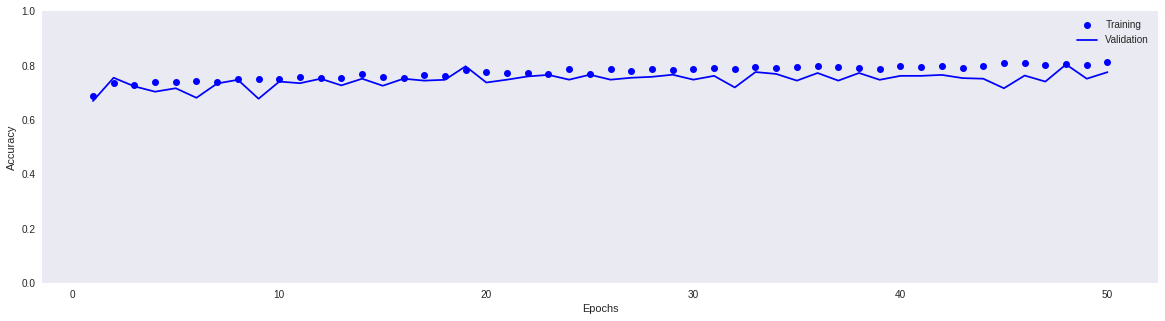

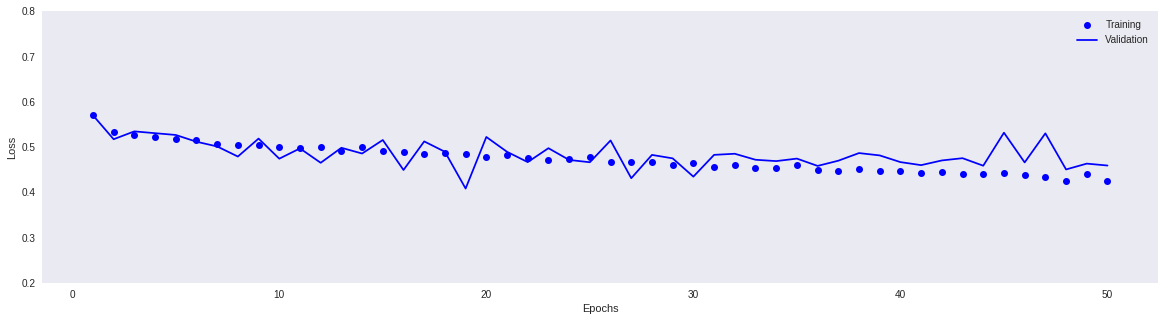

In [65]:
# Plot the results
epochs = range(1, 50 + 1)
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy plot
plt.figure(figsize = (20, 5))
plt.plot(epochs, acc, 'bo', label='Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize = (20, 5))
plt.plot(epochs, loss, 'bo', label='Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0.2, 0.8])
plt.grid()
plt.legend()
plt.show()

There aren't any signs of overfitting and I'd say a few more epochs could be added to make the result even more accurate. Overall the plots seem reasonable, though the validation plots are a bit bumpy.

## 6. Evaluation
The test accuracy is a bit worse than the validation as it should be. Now the test generator wasn't rescaled when this was ran, so the evaluation isn't the most accurate it could be.

In [0]:
r = model.evaluate_generator(test_generator, steps = 7)

In [69]:
print("Test loss: ",r[0])
print("Test accuracy", r[1])

Test loss:  3.747943062470554
Test accuracy 0.7602905587769017


## 7. Results and Discussion
The receiver operating characteristic curve is far from perfect and I feel like it's caused by the lack of images of symptoms.

That would also explain why Sensivity and Precision are so small (0.64 and 0.519), most of the symptom images are probably mixed up with the non-symptom images. By feeding the network mainly asymptomatic pictures it becomes mainly optimized to recognize the ones that doesn't have any symptoms. This means it also misses the images with symptoms more easily. Spesificity is very high, 0.79, which suggests even more that the network is biased towards healthy patients.

In [0]:
#I tried calculating the ROC curve and values my own way but the structure of the test_generator is just too hazardous.
#Source: https://github.com/sakluk/cognitive-systems-for-health-technology/blob/Case-2/Week%205.%20Complex%20model%20and%20metrics.ipynb
#and http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

y_true = np.zeros(413)
y_score = np.zeros(413)
sample_count = 413
i = 0
for inputs_batch, labels_batch in test_generator:
        predicts_batch = model.predict(inputs_batch)
        L = labels_batch.shape[0]
        index = range(i, i + L)
        y_true[index] = labels_batch.ravel()
        y_score[index] = predicts_batch.ravel()
        i = i + L
        if i >= sample_count:
            break

In [0]:

fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)

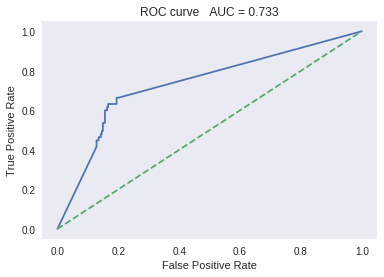

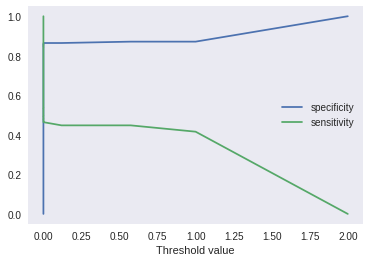

In [106]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve   AUC = {:.3f}'.format(auc))
plt.show()

plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [0]:
# http://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

#Selected 0 threshold since it's the only place where the two line meet.
#It also seems to get the best results.
th = 0

In [102]:
acc = accuracy_score(y_true, y_score > th)
prec = precision_score(y_true, y_score > th)
f1 = f1_score(y_true, y_score > th)
recall = recall_score(y_true, y_score > th)

print('Accuracy:  {:.3f}'.format(acc))
print('Precision: {:.3f}'.format(prec))
print('Recall:    {:.3f}'.format(recall))
print('F1:        {:.3f}'.format(f1))

Accuracy:  0.755
Precision: 0.519
Recall:    0.642
F1:        0.574


In [103]:
print('Classification report')
print(classification_report(y_true, y_score > th, labels = [1.0, 0.0], target_names = ['Disease', 'Healthy']))

Classification report
             precision    recall  f1-score   support

    Disease       0.52      0.64      0.57       106
    Healthy       0.87      0.79      0.83       307

avg / total       0.78      0.76      0.76       413



## 8. Conclusions

I think it's safe to say the results can't be trusted in a medical sense. Even though the overall accuracy seems to be alright, the material is highly biased towards healthy people which also makes the network mostly ignore the people with any diabetic retinopathy symptoms. For example the precision of 51% means that the network is just tossing a coin every time when a symptomatic person is encountered.

For a better result the network should be ran using way more symptomatic images as it has troubles recognizing them right now.